# Setup

In [1]:
# Auto reload settings
#%%

%load_ext autoreload
%autoreload 2
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
# Imports

%load_ext autoreload
import sys

from entropy_aware_search.hf_utils import DataArguments, ModelArguments, get_tokenizer, get_model
from entropy_aware_search.utils import compute_average_across_sequences, process_datapoint
from fine_tune_writing_prompts import get_writing_prompt_dataset, get_tokenized_prompt_dataset
from utils import get_compute_metrics_func
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling
from parlai.utils.strings import colorize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import copy
pd.options.plotting.backend = "matplotlib"



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: cannot import name 'get_tokenized_prompt_dataset' from 'fine_tune_writing_prompts' (/home/mila/a/arorakus/wdir/entropy_aware_search/text_completion/writing_prompts/fine_tune_writing_prompts.py)

In [ ]:
# beautify graphs.

sns.set_style('whitegrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('font', size=11)          # controls default text sizes

palatte=sns.color_palette('pastel')
palatte

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [27]:
# Load GPT2 model fine-tuned on writing prompts

# gpt2_writing_prompt_modelfile = "/home/mila/a/arorakus/scratch/ews/finetuned_writing_prompts/08-14-2022-11-03/checkpoint-71000/"
# gpt2_writing_prompt_modelfile = "/home/mila/a/arorakus/scratch/ews/finetuned_writing_prompts/08-18-2022-05-33-01/checkpoint-55000/"
# gpt2_writing_prompt_modelfile = "/home/mila/a/arorakus/scratch/ews/finetuned_writing_prompts/11-30-2022-21-10-06/checkpoint-31000/"
gpt2_writing_prompt_modelfile = "/home/mila/a/arorakus//scratch/ews/finetuned_writing_prompts/12-11-2022-12-33-26/checkpoint-18000/"
# gpt2_writing_prompt_modelfile = 'gpt2-xl'
model_args = ModelArguments(
    model_name_or_path=gpt2_writing_prompt_modelfile,   
)
gpt2_model = get_model(model_args)
gpt2_model.to('cuda')
tokenizer = get_tokenizer(model_args)
tokenizer.pad_token = tokenizer.eos_token
gpt2_model = gpt2_model.to('cuda')

# compute_metrics = get_compute_metrics_func(experiment_id="jupyter_ipynb", metric_names=['accuracy', 'mauve'])

In [3]:
from typing import List, Union
from parlai.utils.strings import colorize
import copy
def compute_ngram_repeats(context: Union[str, List], model_text: Union[str, List], n=3, splitted=False):
    cgrams = {}
    # compute N grams of the context
    
    if not splitted:
        context = context.split(' ')
        model_text = model_text.split(' ')

    for i in range(n, len(context) + 1):
        ngram = ' '.join(context[i - n : i])
        cgrams[ngram] = True
    # compute N grams of the model response
    creps = 0
    lreps = 0
    repetition_idxs = [0] * len(model_text)
    lreps_idxs = [0] * len(model_text)
    creps_idxs = [0] * len(model_text)
    
    lgrams = {}

    for i in range(n, len(model_text) + 1):
        ngram = ' '.join(model_text[i - n : i])
        
        if ngram in cgrams:
            creps = creps + 1
            repetition_idxs[i-1] = 1
            creps_idxs[i-1] = 1
        
        if ngram in lgrams:
            lreps = lreps + 1
            repetition_idxs[i-1] = 1
            lreps_idxs[i-1] = 1
           
        lgrams[ngram] = True
    
    for i in range(n-1, len(model_text)):
        if repetition_idxs[i] == 1:
            for j in range(1, n):
                repetition_idxs[i-j] = 1

        if creps_idxs[i] == 1:
            for j in range(1, n):
                creps_idxs[i-j] = 1

        if lreps_idxs[i] == 1:
            for j in range(1, n):
                lreps_idxs[i-j] = 1

    return creps + lreps, creps, lreps, repetition_idxs, creps_idxs, lreps_idxs


def print_with_colors(text, repeat_indices):
    colorized_tokens = []
    tokenized_text = text.split(" ")
    
    is_repeat_indices = copy.copy(repeat_indices)
    for (token, is_repeat) in zip(tokenized_text, is_repeat_indices):
       
        if is_repeat:
            colorized_token = colorize(token, "red")
        else:
            colorized_token = token

        colorized_tokens.append(colorized_token)

    return " ".join(colorized_tokens)

def print_sample(context, model_text, repeat_type='all'):
    _, _, _, arep_idxs, crep_idxs, lrep_idxs = compute_ngram_repeats(context, model_text)
    # print(context)

    rep_idxs = None
    if repeat_type == 'all':
        rep_idxs = arep_idxs
    elif repeat_type == 'context':
        rep_idxs = crep_idxs
    elif repeat_type == 'labels':
        rep_idxs = lrep_idxs

    print(print_with_colors(model_text, rep_idxs))

In [16]:
# Plot mean and std average entropy

def plot_avg_entropies_mean_std(entropies, label=None, ax=None,  color='red', linewidth=1, std_dev=1):
    entropy_mean = np.ma.mean(entropies, axis=0)
    entropy_std = np.ma.std(entropies, axis=0)
    ax = sns.lineplot(y=entropy_mean, x=np.arange(len(entropy_mean)), 
                    ax=ax, label=label, color=color, linewidth=linewidth)
    # sns.lineplot(entropy_mean, ax=ax, label=label)

    ax.set_ylim(0,6)
    ax.fill_between(range(len(entropy_mean)), entropy_mean -  std_dev * entropy_std, 
                                                entropy_mean +  std_dev * entropy_std, alpha=0.1, color=color)
    # ax=ax.set_xticks(np.arange(len(entropy_mean)), step=100)


# Constants

In [4]:
# Data
orig_wp = '/home/mila/a/arorakus/wdir/entropy_aware_search/data/writingPrompts/generated/orig.jsonl'
gpt2_greedy_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/writingPrompts/generated/finetuned/greedy.csv"
gpt2_beam_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/writingPrompts/generated/finetuned/beam_10.csv"
gpt2_nucleus_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/writingPrompts/generated/finetuned/top_p_0.9.csv"
gpt2_topk_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/writingPrompts/generated/finetuned/top_k_30.csv"
gpt2_typical_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/writingPrompts/generated/finetuned/typical_p_0.95.csv"
gpt2_entropy_greedy_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/writingPrompts/generated/finetuned/eag_5_1.5.csv"
gpt2_entropy_beam_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/writingPrompts/generated/finetuned/beam_5_eab.csv"

In [5]:
NUM_SEQ=1000
MAX_LEN = 1000
WIDTH = 5

# Entropy of Human Data

In [6]:
human_dataframe = pd.read_json(orig_wp, lines=True)

NameError: name 'pd' is not defined

In [22]:
human_datapoint = human_dataframe.iloc[10]
print(human_datapoint.context)
print()
print(print_sample(human_datapoint.context, human_datapoint.model_text))

[ WP ] A magical mirror shows your reflection and your future soulmate . You only see your reflection .


Carnival music seemed to dance in the background . A cacophony of color and knick knacks decorated the fairgrounds . It was just another day at the carnival . I sit at my stand reading another old junky sci-fi novel .
 “ So how much to see it ? ”
 Some pre-teen girl interrupted my book with her piercing voice . I sigh towards her and lean in .
 “ Ten dollars , just like the sign says. ”
 “ And it works ? ”
 “ So I ’ m told . ”
 “ You mean you ’ ve never looked ? ”
 “ Nope , ” I say , picking my book back up .
 “ Well why not. ”
 “ Because some things in this life should be a mystery , ” I reply .
 “ Well I want to see , ” she says . I tap on the money box and she places her ten dollars in . I watch her go in and wait for the audible reaction . After a couple of seconds I can hear an excited squeal . She runs out jumping up and down .
 “ He ’ s so handsome ! ”
 I can see her run off

## Compute Average entropy across sequences.

In [28]:
# human_avg_entropy_pd, human_entropies = compute_average_across_sequences(human_dataframe, gpt2_model, tokenizer, column_prefix='human_generated',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)
_, human_ma_entropies = compute_average_across_sequences(human_dataframe, gpt2_model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/c4e60dd23ac1f240ed0010e954bfcfcc-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-1000-1000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/c4e60dd23ac1f240ed0010e954bfcfcc-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-1000-1000-entropy_ma-5-avgs.csv


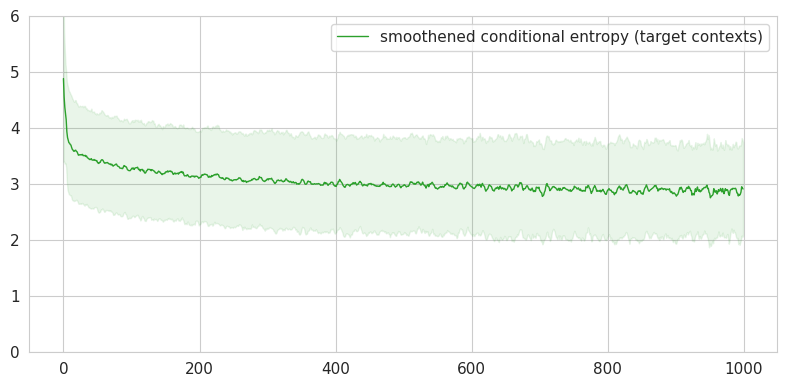

In [29]:
fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
# plot_avg_entropies_mean_std(human_entropies, ax, 'human data entropy', color='darkgreen')
plot_avg_entropies_mean_std(human_ma_entropies, 'smoothened conditional entropy (target contexts)', ax=ax, color='tab:green', linewidth=1.0)

## Examples of generation

In [30]:

lpdh = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=WIDTH, max_len=MAX_LEN,
)

: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


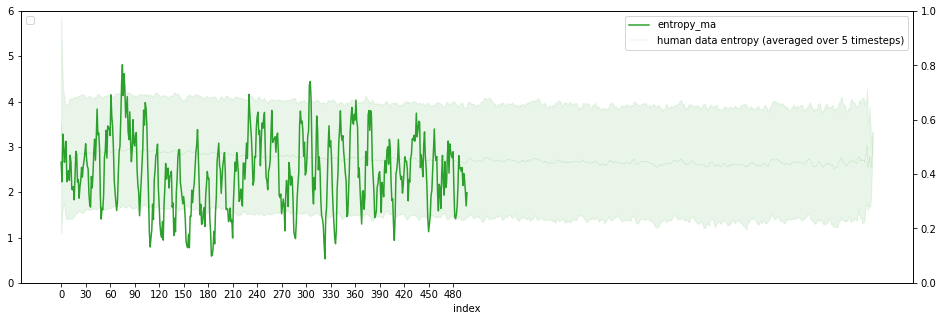

In [13]:
fig, ax = plt.subplots(figsize=(16, 5))
ax2 = ax.twinx()
# lpdh.plot.bar(x='index', y='is_lrep', ax=ax2, fill=True, rot='60')
ax2.legend(loc=2)

# lpdh.plot(x="index", y='entropy', ylim=(0,8), ax=ax, color='darkgreen')
lpdh.plot(x="index", y='entropy_ma', ylim=(0,5), ax=ax, color='tab:green')
ax.set_xticks(np.arange(len(lpdh['index']), step=30))

plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)

# Entropy of Model Data

In [14]:
model_greedy_dataframe = pd.read_csv(gpt2_greedy_generation, sep='\t', names=['context', 'model_text'])
model_greedy_dataframe['model_text'] = model_greedy_dataframe['model_text'].apply(lambda txt: txt.replace("<newline>", "\n"))

model_beam_dataframe = pd.read_csv(gpt2_beam_generation, sep='\t', names=['context', 'model_text'])
model_beam_dataframe['model_text'] = model_beam_dataframe['model_text'].apply(lambda txt: txt.replace("<newline>", "\n"))

model_nucleus_dataframe = pd.read_csv(gpt2_nucleus_generation, sep='\t', names=['context', 'model_text'])
model_nucleus_dataframe['model_text'] = model_nucleus_dataframe['model_text'].apply(lambda txt: txt.replace("<newline>", "\n"))

model_topk_dataframe = pd.read_csv(gpt2_topk_generation, sep='\t', names=['context', 'model_text'])
model_topk_dataframe['model_text'] = model_topk_dataframe['model_text'].apply(lambda txt: txt.replace("<newline>", "\n"))

model_typical_dataframe = pd.read_csv(gpt2_typical_generation, sep='\t', names=['context', 'model_text'])
model_typical_dataframe['model_text'] = model_typical_dataframe['model_text'].apply(lambda txt: txt.replace("<newline>", "\n"))


model_eag_dataframe = pd.read_csv(gpt2_entropy_greedy_generation, sep='\t', names=['context', 'model_text', 'voilations', 'entropies'])
model_eag_dataframe['model_text'] = model_eag_dataframe['model_text'].apply(lambda txt: txt.replace("<newline>", "\n"))


model_eabs_dataframe = pd.read_csv(gpt2_entropy_beam_generation, sep='\t', names=['context', 'model_text', 'voilations', 'entropies'])
model_eabs_dataframe['model_text'] = model_eabs_dataframe['model_text'].apply(lambda txt: txt.replace("<newline>", "\n"))


In [15]:
human_datapoint_idx = human_dataframe[(human_dataframe.model_text == human_datapoint.model_text)].index.item()

print(human_datapoint_idx)

human_datapoint_idx=26

10


In [16]:
human_datapoint = human_dataframe.iloc[human_datapoint_idx]
greedy_sample = model_greedy_dataframe.iloc[human_datapoint_idx]
beam_sample = model_beam_dataframe.iloc[human_datapoint_idx]
nucleus_sample = model_nucleus_dataframe.iloc[human_datapoint_idx]
topk_sample = model_topk_dataframe.iloc[human_datapoint_idx]
typical_sample = model_typical_dataframe.iloc[human_datapoint_idx]
eag_sample = model_eag_dataframe.iloc[human_datapoint_idx]
eabs_sample = model_eabs_dataframe.iloc[human_datapoint_idx * 10]

print("Context:")
print(human_datapoint.context)
print()
print("Greedy Model Text: ")
print_sample(human_datapoint.context, greedy_sample.model_text.replace("\n", "\\n"))
print()
print("Beam Model Text: ")
print_sample(human_datapoint.context, beam_sample.model_text.replace("\n", "\\n"))
print()
print("Nucleus sampled Model Text:")
print_sample(human_datapoint.context, nucleus_sample.model_text.replace("\n", "\\n"))
print()
print("Top-K sampled Model Text:")
print_sample(human_datapoint.context, topk_sample.model_text.replace("\n", "\\n"))
print()

print("Typical Model Text: ")
print_sample(human_datapoint.context, typical_sample.model_text.replace("\n", "\\n"))
print()

print("EAG Model Text:")
print_sample(human_datapoint.context, eag_sample.model_text.replace("\n", "\\n"))
print(f"Num. Voilations: {eag_sample.voilations}")
print()

print("EABS Model Text:")
print_sample(human_datapoint.context, eabs_sample.model_text.replace("\n", "\\n"))
print(f"Num. Voilations: {eabs_sample.voilations}")
print()

Context:
[ WP ] You just started a new job in a large office building and what you do n't know is that at twelve o'clock every day , there is a office wide Purge style battle to the death , those who survive an hour get a significant pay raise and can come back tomorrow . A bell just went off , it 's twelve o'clock .

Greedy Model Text: 
I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. I wasn't sure what to expect. 

<AxesSubplot:xlabel='index'>

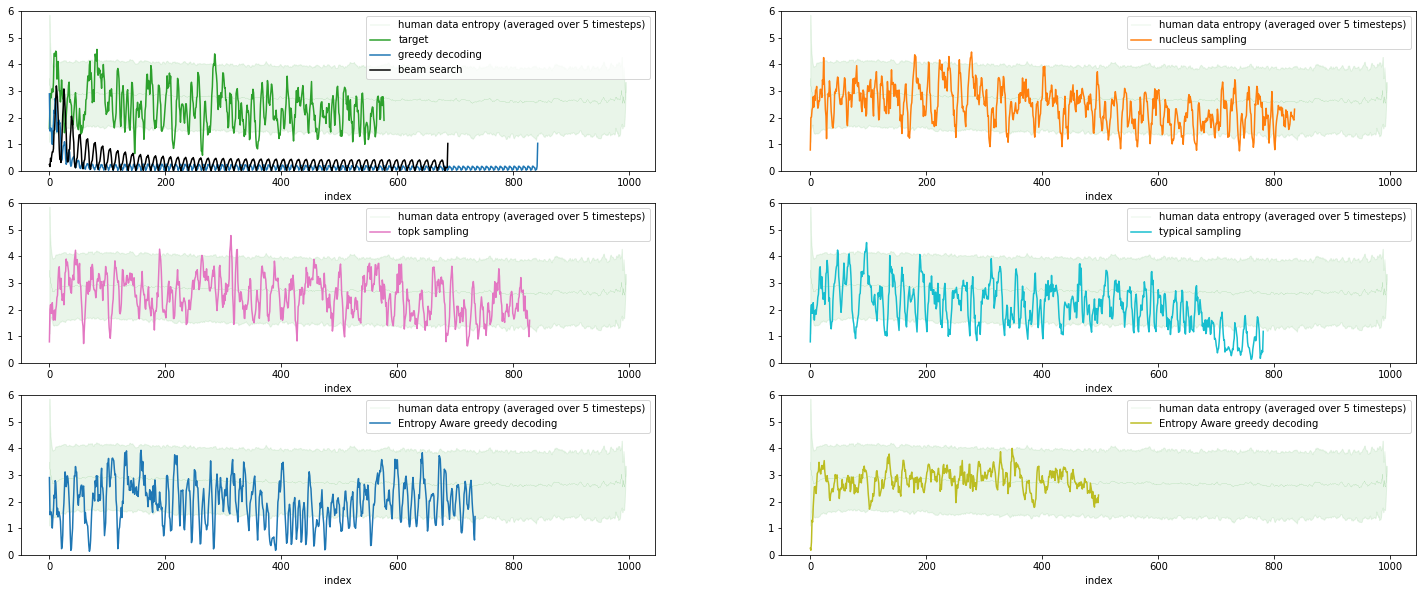

In [17]:
lpdh = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=5, max_len=MAX_LEN,
)

greedy_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=greedy_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

beam_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=beam_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)


nucleus_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=nucleus_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

topk_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=topk_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

typical_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=typical_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

eag_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=eag_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)


eabs_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=eabs_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

fig, axs = plt.subplots(3,2, figsize=(25, 10))
plot_avg_entropies_mean_std(human_ma_entropies, axs[0, 0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
lpdh.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0,0], label='target', color='tab:green')
greedy_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0, 0], label='greedy decoding', color='tab:blue')
beam_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0, 0], label='beam search', color='black')

plot_avg_entropies_mean_std(human_ma_entropies, axs[0, 1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
nucleus_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0, 1], label='nucleus sampling', color='tab:orange')

plot_avg_entropies_mean_std(human_ma_entropies, axs[1,0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
topk_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1,0], label='topk sampling', color='tab:pink')

plot_avg_entropies_mean_std(human_ma_entropies, axs[1,1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
typical_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1,1], label='typical sampling', color='tab:cyan')


plot_avg_entropies_mean_std(human_ma_entropies, axs[2,0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
eag_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[2, 0], label='Entropy Aware greedy decoding', color='tab:blue')

plot_avg_entropies_mean_std(human_ma_entropies, axs[2,1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
eabs_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[2, 1], label='Entropy Aware greedy decoding', color='tab:olive')



# fig.delaxes(axs[2,1])
# # ax.set_xticklabels(lpdm['token'])
# ax.set_xlabel("Timestep")
# ax.set_ylabel("Entropy (Averaged over 5 timesteps)")

## Generate using Entropy Aware Greedy Search

In [18]:
%%script false --no-raise-error

tokenizer.pad_token = tokenizer.eos_token

tokenized_context = tokenizer(human_datapoint.context, return_tensors="pt")
tokenized_context = tokenized_context.to('cuda')

gpt2_model.greedy_search(**tokenized_context, max_length=1024, pad_token_id=tokenizer.eos_token_id)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
%%script false --no-raise-error
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
test_dataloader = DataLoader(tokenized_writing_prompt_testset, collate_fn=data_collator, batch_size=1)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Compute Average entropy across timesteps.

### For all model generated data

In [20]:
# Greedy
model_gen_greedy_avg_entropy_pd, model_gen_greedy_entropies = compute_average_across_sequences(model_greedy_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_greedy',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_greedy_avg_ma_entropy_pd, model_gen_greedy_ma_entropies = compute_average_across_sequences(model_greedy_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_greedy', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

KeyboardInterrupt: 

In [ ]:
# Nucleus
model_gen_nucleus_avg_entropy_pd, model_gen_nucleus_entropies = compute_average_across_sequences(model_nucleus_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_nucleus',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_nucleus_avg_ma_entropy_pd, model_gen_nucleus_ma_entropies = compute_average_across_sequences(model_nucleus_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_nucleus', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)


In [ ]:
# Topk
model_gen_topk_avg_entropy_pd, model_gen_topk_entropies = compute_average_across_sequences(model_topk_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_topk',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_topk_avg_ma_entropy_pd, model_gen_topk_ma_entropies = compute_average_across_sequences(model_topk_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_topk', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)


In [ ]:
# Typical Decoding
model_gen_typical_avg_entropy_pd, model_gen_typical_entropies = compute_average_across_sequences(model_typical_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_typical_search',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

model_gen_typical_avg_ma_entropy_pd, model_gen_typical_ma_entropies = compute_average_across_sequences(model_typical_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_typical_search', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

<AxesSubplot:title={'center':'Average Entropy vs Timesteps (Model Data w/ Repetition)'}, xlabel='Timesteps', ylabel='Average Entropy'>

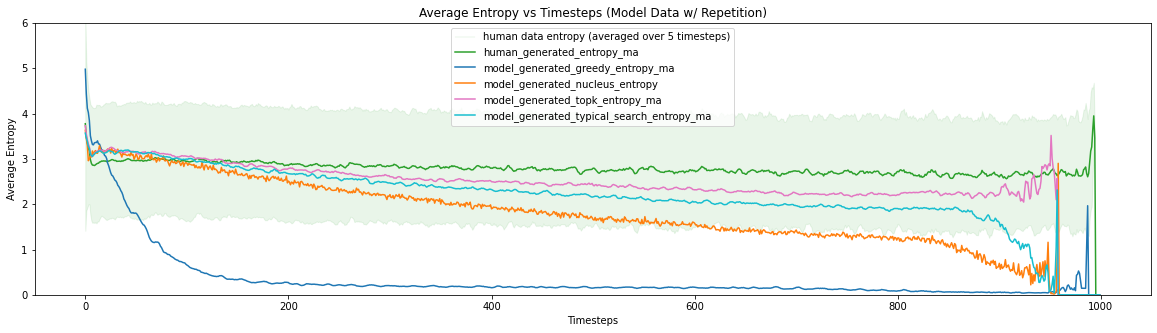

In [ ]:
model_vs_human_avg_entropies = pd.concat([human_avg_ma_entropy_pd, model_gen_greedy_avg_ma_entropy_pd, model_gen_nucleus_avg_entropy_pd, model_gen_topk_avg_ma_entropy_pd, model_gen_typical_avg_ma_entropy_pd],axis=1)

fig, ax = plt.subplots(figsize=(20, 5))

plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)

styles=['tab:green', 'tab:blue', 'tab:orange', 'tab:pink', 'tab:cyan']
model_vs_human_avg_entropies.plot( 
    title='Average Entropy vs Timesteps', 
    figsize=(20, 5),
    xlabel="Timesteps", 
    ylabel="Average Entropy",
    style=styles,
    ax=ax
)


# Analysis to discover entropy awareness criteria

In [78]:

human_datapoint = human_dataframe.sample().iloc[0]
human_datapoint_idx = human_dataframe[(human_dataframe.model_text == human_datapoint.model_text)].index.item()

human_datapoint = human_dataframe.iloc[human_datapoint_idx]
greedy_sample = model_greedy_dataframe.iloc[human_datapoint_idx]
beam_sample = model_beam_dataframe.iloc[human_datapoint_idx]



Greedy Model Text: 
The first time I saw her, I was so excited. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able 

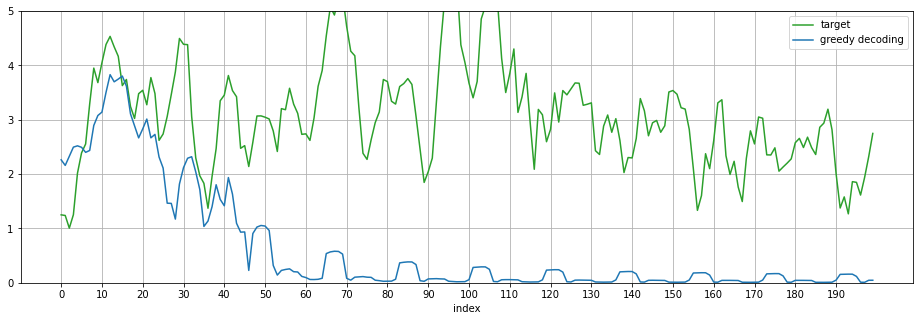

In [79]:
fig, ax = plt.subplots(figsize=(16,5))

lpdh = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=5, max_len=MAX_LEN,
)
lpdh['dent_cumsum'] = lpdh['dent'].cumsum()

greedy_labeled_datapoint = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=greedy_sample, width=5, max_len=MAX_LEN, 
)
greedy_labeled_datapoint['dent_cumsum'] = greedy_labeled_datapoint['dent'].cumsum()

beam_labeled_datapoint = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=beam_sample, width=5, max_len=MAX_LEN,
)
beam_labeled_datapoint['dent'] = beam_labeled_datapoint['dent'].cumsum()

# plot_avg_entropies_mean_std(human_ma_entropies[:], ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
lpdh[:200].plot(x="index", y='entropy_ma', ylim=(-0,5), ax=ax, label='target', color='tab:green')


greedy_labeled_datapoint[:200].plot(x="index", y='entropy_ma', ylim=(0,5), ax=ax, label='greedy decoding', color='tab:blue')
# greedy_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,5), ax=ax, label='greedy decoding', color='tab:orange')

ax.set_xticks(np.arange(len(greedy_labeled_datapoint[:200]['index']), step=10))
plt.grid()

print("Greedy Model Text: ")
print_sample(human_datapoint.context, greedy_sample.model_text.replace("\n", "<n>"))
print()

In [80]:
greedy_labeled_datapoint['token'][20:50]

20         Ġto
21         Ġbe
22       Ġable
23         Ġto
24       Ġhold
25        Ġher
26         Ġin
27         Ġmy
28       Ġarms
29           .
30          ĠI
31        Ġwas
32         Ġso
33    Ġexcited
34         Ġto
35        Ġsee
36        Ġher
37           ,
38         Ġto
39         Ġbe
40       Ġable
41         Ġto
42       Ġhold
43        Ġher
44         Ġin
45         Ġmy
46       Ġarms
47           .
48          ĠI
49        Ġwas
Name: token, dtype: object

In [1]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = human_dataframe[human_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_greedy_dataframe[model_greedy_dataframe.
_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_topk_dataframe[model_entropy_topk_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_aware_greedy_dataframe[model_entropy_aware_greedy_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        xticks=range(0, 120, 5),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        )

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        # xticks=range(0, 128),
        yticks=np.arange(0, 11, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # label="CDF"
)

ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences (w/o length normalization.")

NameError: name 'plt' is not defined